In [ ]:
%whos

Interactive namespace is empty.


In [ ]:
!pip install -q yfinance transformers torch ta tqdm scikit-learn seaborn pandas numpy matplotlib

  Preparing metadata (setup.py) ... done


In [ ]:
#!pip install pytorch-lightning pytorch-forecasting --quiet
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 22.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import ta
import re
import torch
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-v0_8")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

NEWS_PATH = "/content/drive/MyDrive/Feature_Engineering/raw_partner_headlines.csv"

news_df = pd.read_csv(NEWS_PATH)

print("Loaded news shape:", news_df.shape)
news_df.head()

Loaded news shape: (1845559, 6)


,Unnamed: 0,headline,url,publisher,date,stock
0,2,Agilent Technologies Announces Pricing of $5……...,http://www.gurufocus.com/news/1153187/agilent-...,GuruFocus,2020-06-01 00:00:00,A
1,3,Agilent (A) Gears Up for Q2 Earnings: What's i...,http://www.zacks.com/stock/news/931205/agilent...,Zacks,2020-05-18 00:00:00,A
2,4,J.P. Morgan Asset Management Announces Liquida...,http://www.gurufocus.com/news/1138923/jp-morga...,GuruFocus,2020-05-15 00:00:00,A
3,5,"Pershing Square Capital Management, L.P. Buys ...",http://www.gurufocus.com/news/1138704/pershing...,GuruFocus,2020-05-15 00:00:00,A
4,6,Agilent Awards Trilogy Sciences with a Golden ...,http://www.gurufocus.com/news/1134012/agilent-...,GuruFocus,2020-05-12 00:00:00,A


In [ ]:
news_df = news_df.rename(columns={
    "date": "date",
    "stock": "ticker",
    "headline": "headline",
})

news_df = news_df[["date", "ticker", "headline"]].dropna()
news_df["date"] = pd.to_datetime(news_df["date"])
news_df = news_df.sort_values(["ticker", "date"]).reset_index(drop=True)

Filter Top Tickers and substitute with YFiance data id needed

In [ ]:
top_tickers = news_df['ticker'].value_counts().head(25).index.tolist()
news_df = news_df[news_df['ticker'].isin(top_tickers)]

print("Top tickers:", top_tickers)

Top tickers: ['KR', 'GXC', 'PGJ', 'YINN', 'JPM', 'FXP', 'XPP', 'FCAU', 'CHN', 'JWN', 'ERO', 'RSP', 'OXY', 'DISH', 'BLK', 'VGK', 'MDT', 'UGAZ', 'KEY', 'AVGO', 'TJX', 'VNQ', 'INTC', 'MYL', 'DGAZ']


In [ ]:
# Filter valid tickers
def ticker_valid(t):
    try:
        hist = yf.Ticker(t).history(period="5d")
        return not hist.empty
    except:
        return False

valid_tickers = [t for t in top_tickers if ticker_valid(t)]

print("Valid tickers:", valid_tickers)

ERROR:yfinance:$FCAU: possibly delisted; no price data found  (period=5d) (Yahoo error = "No data found, symbol may be delisted")
ERROR:yfinance:$CHN: possibly delisted; no price data found  (period=5d)
ERROR:yfinance:$JWN: possibly delisted; no price data found  (period=5d) (Yahoo error = "No data found, symbol may be delisted")
ERROR:yfinance:$DISH: possibly delisted; no price data found  (period=5d) (Yahoo error = "No data found, symbol may be delisted")
ERROR:yfinance:$UGAZ: possibly delisted; no price data found  (period=5d)
ERROR:yfinance:$MYL: possibly delisted; no price data found  (period=5d) (Yahoo error = "No data found, symbol may be delisted")
ERROR:yfinance:$DGAZ: possibly delisted; no price data found  (period=5d)


Valid tickers: ['KR', 'GXC', 'PGJ', 'YINN', 'JPM', 'FXP', 'XPP', 'ERO', 'RSP', 'OXY', 'BLK', 'VGK', 'MDT', 'KEY', 'AVGO', 'TJX', 'VNQ', 'INTC']


In [ ]:
import yfinance as yf
import pandas as pd
# Download price data
def download_prices(ticker_list, start, end):
    frames = []

    for t in ticker_list:
        print("Downloading:", t)

        df = yf.download(
            tickers=[t],
            start=start,
            end=end,
            progress=False,
            group_by="ticker"     # ensures MultiIndex structure
        )

        if df.empty:
            print("No data for", t)
            continue

        # Flatten multiindex column names
        df.columns = [
            (col[1] if isinstance(col, tuple) else col)
            for col in df.columns
        ]

        df['ticker'] = t
        df.reset_index(inplace=True)

        frames.append(df)

    if not frames:
        raise ValueError("No tickers downloaded")

    return pd.concat(frames, ignore_index=True)


In [ ]:
start_date = news_df['date'].min().strftime("%Y-%m-%d")
end_date   = news_df['date'].max().strftime("%Y-%m-%d")

prices_df = download_prices(valid_tickers, start_date, end_date)

print("Price Data Shape:", prices_df.shape)
prices_df.head()

/tmp/ipython-input-3790827248.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(


Downloading: KR
Downloading: GXC


/tmp/ipython-input-3790827248.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(


Downloading: PGJ
Downloading: YINN


/tmp/ipython-input-3790827248.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(
/tmp/ipython-input-3790827248.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(


Downloading: JPM


/tmp/ipython-input-3790827248.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(


Downloading: FXP
Downloading: XPP


/tmp/ipython-input-3790827248.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(
/tmp/ipython-input-3790827248.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(


Downloading: ERO
Downloading: RSP


/tmp/ipython-input-3790827248.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(
/tmp/ipython-input-3790827248.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(


Downloading: OXY


/tmp/ipython-input-3790827248.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(


Downloading: BLK
Downloading: VGK


/tmp/ipython-input-3790827248.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(
/tmp/ipython-input-3790827248.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(


Downloading: MDT


/tmp/ipython-input-3790827248.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(


Downloading: KEY


/tmp/ipython-input-3790827248.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(


Downloading: AVGO


/tmp/ipython-input-3790827248.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(


Downloading: TJX


/tmp/ipython-input-3790827248.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(


Downloading: VNQ


/tmp/ipython-input-3790827248.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(


Downloading: INTC


/tmp/ipython-input-3790827248.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(


Price Data Shape: (44858, 7)


,Date,Open,High,Low,Close,Volume,ticker
0,2010-02-04,7.915872,8.000909,7.812348,7.823440,21101000,KR
1,2010-02-05,7.819745,7.897388,7.764286,7.830837,15802000,KR
2,2010-02-08,7.827139,7.878901,7.745799,7.812350,12450600,KR
3,2010-02-09,7.912175,7.915873,7.841927,7.901084,10143600,KR
4,2010-02-10,7.902942,7.947507,7.865804,7.884372,9254800,KR


Normalize Cloumns

In [ ]:
# Convert column names to lowercase
prices_df.columns = [c.lower() for c in prices_df.columns]

prices_df = prices_df.rename(columns={
    'date': 'date',
    'open': 'open',
    'high': 'high',
    'low': 'low',
    'close': 'close',
    'adj close': 'adj_close',
    'volume': 'volume'
})

prices_df.head()

,date,open,high,low,close,volume,ticker
0,2010-02-04,7.915872,8.000909,7.812348,7.823440,21101000,KR
1,2010-02-05,7.819745,7.897388,7.764286,7.830837,15802000,KR
2,2010-02-08,7.827139,7.878901,7.745799,7.812350,12450600,KR
3,2010-02-09,7.912175,7.915873,7.841927,7.901084,10143600,KR
4,2010-02-10,7.902942,7.947507,7.865804,7.884372,9254800,KR


In [ ]:
import ta
# Technical Indicators
def add_ta(df):
    df = df.sort_values("date").copy()
    df["ma10"] = df["close"].rolling(10).mean()
    df["ma20"] = df["close"].rolling(20).mean()
    df["volatility"] = df["close"].pct_change().rolling(20).std()
    df["rsi14"] = ta.momentum.RSIIndicator(df["close"], 14).rsi()
    return df

prices_ta = prices_df.groupby("ticker", group_keys=False).apply(add_ta)
prices_ta.head()

/tmp/ipython-input-4210701099.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  prices_ta = prices_df.groupby("ticker", group_keys=False).apply(add_ta)


,date,open,high,low,close,volume,ticker,ma10,ma20,volatility,rsi14
0,2010-02-04,7.915872,8.000909,7.812348,7.823440,21101000,KR,NaN,NaN,NaN,NaN
1,2010-02-05,7.819745,7.897388,7.764286,7.830837,15802000,KR,NaN,NaN,NaN,NaN
2,2010-02-08,7.827139,7.878901,7.745799,7.812350,12450600,KR,NaN,NaN,NaN,NaN
3,2010-02-09,7.912175,7.915873,7.841927,7.901084,10143600,KR,NaN,NaN,NaN,NaN
4,2010-02-10,7.902942,7.947507,7.865804,7.884372,9254800,KR,NaN,NaN,NaN,NaN


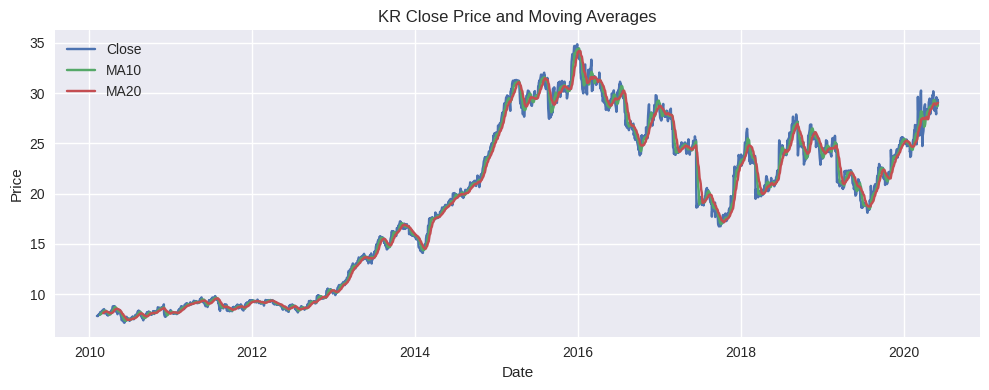

In [ ]:
sample_ticker = prices_ta["ticker"].iloc[0]  # or set to "JPM", "KR", etc.
sample_df = prices_ta[prices_ta["ticker"] == sample_ticker].sort_values("date")

plt.figure(figsize=(10, 4))
plt.plot(sample_df["date"], sample_df["close"], label="Close")
plt.plot(sample_df["date"], sample_df["ma10"], label="MA10")
plt.plot(sample_df["date"], sample_df["ma20"], label="MA20")
plt.title(f"{sample_ticker} Close Price and Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()

Multi day Returns

In [ ]:
def add_labels(df, threshold=0.004):
    df = df.sort_values("date").copy()

    df["next_close_10"] = df["close"].shift(-10)
    df["ret10"] = (df["next_close_10"] - df["close"]) / df["close"]

    def classify(r):
        if r > threshold:
            return 1
        elif r < -threshold:
            return -1
        else:
            return 0

    df["direction"] = df["ret10"].apply(classify)
    return df

prices_final = prices_ta.groupby("ticker", group_keys=False).apply(add_labels)

/tmp/ipython-input-3619024689.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  prices_final = prices_ta.groupby("ticker", group_keys=False).apply(add_labels)


In [ ]:
df = prices_final.copy()
df = df.dropna(subset=["ma10", "ma20", "volatility", "rsi14", "direction"])
df = df.sort_values(["ticker", "date"]).reset_index(drop=True)

print("Final feature dataframe:", df.shape)
df.head()


Final feature dataframe: (44498, 14)


,date,open,high,low,close,volume,ticker,ma10,ma20,volatility,rsi14,next_close_10,ret10,direction
0,2010-03-05,1.344515,1.387568,1.344515,1.366394,3767000,AVGO,1.292005,1.254245,0.010637,88.465196,1.419327,0.038739,1
1,2010-03-08,1.374863,1.377686,1.347338,1.362865,2220000,AVGO,1.305838,1.261691,0.010692,86.231638,1.407329,0.032626,1
2,2010-03-09,1.372040,1.411564,1.351573,1.365688,9227000,AVGO,1.319742,1.269949,0.009979,86.524742,1.427091,0.044961,1
3,2010-03-10,1.373452,1.410152,1.366394,1.393214,5449000,AVGO,1.333858,1.279653,0.010250,88.986358,1.384744,-0.006079,-1
4,2010-03-11,1.396743,1.409447,1.396743,1.401683,3947000,AVGO,1.346350,1.290452,0.009266,89.614996,1.386862,-0.010574,-1


In [ ]:
# Feature columns (technical only)
feature_cols = [
    "open", "high", "low", "close", "volume",
    "ma10", "ma20", "volatility", "rsi14"
]

X = df[feature_cols]
y3 = df["direction"]                       # -1, 0, 1
y2 = (df["direction"] == 1).astype(int)    # binary: Up = 1, else 0

In [ ]:
cut = int(len(df) * 0.8)

X_train = X.iloc[:cut]
X_test  = X.iloc[cut:]
y3_train = y3.iloc[:cut]
y3_test  = y3.iloc[cut:]
y2_train = y2.iloc[:cut]
y2_test  = y2.iloc[cut:]

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

In [ ]:
# Define models
models_mc = {
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42),
    "CatBoost": CatBoostClassifier(
        iterations=300, depth=6, learning_rate=0.05,
        loss_function="MultiClass", verbose=False
    ),
    "XGBoost": XGBClassifier(
        objective="multi:softmax",
        num_class=3,
        eval_metric="mlogloss",
        random_state=42
    ),
    "LightGBM": lgb.LGBMClassifier(
        objective="multiclass",
        num_class=3,
        n_estimators=400,
        learning_rate=0.05
    )
}

In [ ]:
# Remap y3 for XGBoost and LightGBM
map_forward = {-1: 0, 0: 1, 1: 2}      # for XGBoost & LightGBM
map_backward = {0: -1, 1: 0, 2: 1}

y3_train_raw = y3_train.copy()
y3_test_raw  = y3_test.copy()

y3_train_mc = y3_train_raw.map(map_forward)   # for XGB & LGB
y3_test_mc  = y3_test_raw.map(map_forward)

In [ ]:
print("TECHNICAL ONLY — 3-CLASS (10-DAY)")

for name, model in models_mc.items():

    if name in ["XGBoost", "LightGBM"]:
        # train on remapped labels
        model.fit(X_train_s, y3_train_mc)
        raw_pred = model.predict(X_test_s)
        pred = pd.Series(raw_pred).map(map_backward)

    else:
        # models that accept -1,0,1 directly
        model.fit(X_train_s, y3_train_raw)
        pred = model.predict(X_test_s)

    print(f"{name}")
    print("Accuracy:", accuracy_score(y3_test_raw, pred))
    print(classification_report(y3_test_raw, pred))

TECHNICAL ONLY — 3-CLASS (10-DAY)
RandomForest
Accuracy: 0.4650561797752809
              precision    recall  f1-score   support

          -1       0.42      0.41      0.41      3716
           0       0.12      0.02      0.04       622
           1       0.51      0.57      0.54      4562

    accuracy                           0.47      8900
   macro avg       0.35      0.33      0.33      8900
weighted avg       0.44      0.47      0.45      8900

CatBoost
Accuracy: 0.5177528089887641
              precision    recall  f1-score   support

          -1       0.49      0.34      0.40      3716
           0       0.00      0.00      0.00       622
           1       0.53      0.73      0.62      4562

    accuracy                           0.52      8900
   macro avg       0.34      0.36      0.34      8900
weighted avg       0.48      0.52      0.48      8900



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


XGBoost
Accuracy: 0.488876404494382
              precision    recall  f1-score   support

          -1       0.44      0.39      0.41      3716
           0       0.13      0.01      0.01       622
           1       0.52      0.64      0.57      4562

    accuracy                           0.49      8900
   macro avg       0.36      0.34      0.33      8900
weighted avg       0.46      0.49      0.47      8900

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 35598, number of used features: 9
[LightGBM] [Info] Start training from score -0.926682
[LightGBM] [Info] Start training from score -2.485750
[LightGBM] [Info] Start training from score -0.652251
LightGBM
Accuracy: 0.4846067415730337
              precision    recall  f1-score   support

          -1       0.43      0.36      0

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [ ]:
y2_train = y2_train.astype(int)
y2_test  = y2_test.astype(int)

models_bin = {
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42),
    "CatBoost": CatBoostClassifier(
        iterations=300, depth=6, learning_rate=0.05,
        loss_function="Logloss", verbose=False
    ),
    "XGBoost": XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=42
    ),
    "LightGBM": lgb.LGBMClassifier(
        objective="binary", n_estimators=400, learning_rate=0.05
    )
}

In [ ]:
print("TECHNICAL ONLY — BINARY (10-DAY)")

for name, model in models_bin.items():

    if name in ["XGBoost", "LightGBM"]:
        model.fit(X_train_s, y2_train)
        pred = (model.predict(X_test_s) > 0.5).astype(int)

    else:
        model.fit(X_train_s, y2_train)
        pred = model.predict(X_test_s)

    print(f"\n>>> {name}")
    print("Accuracy:", accuracy_score(y2_test, pred))
    print(classification_report(y2_test, pred, target_names=["Down","Up"]))


TECHNICAL ONLY — BINARY (10-DAY)

>>> RandomForest
Accuracy: 0.4901123595505618
              precision    recall  f1-score   support

        Down       0.48      0.47      0.48      4338
          Up       0.50      0.50      0.50      4562

    accuracy                           0.49      8900
   macro avg       0.49      0.49      0.49      8900
weighted avg       0.49      0.49      0.49      8900


>>> CatBoost
Accuracy: 0.5143820224719101
              precision    recall  f1-score   support

        Down       0.50      0.47      0.49      4338
          Up       0.52      0.56      0.54      4562

    accuracy                           0.51      8900
   macro avg       0.51      0.51      0.51      8900
weighted avg       0.51      0.51      0.51      8900


>>> XGBoost
Accuracy: 0.4964044943820225
              precision    recall  f1-score   support

        Down       0.48      0.48      0.48      4338
          Up       0.51      0.51      0.51      4562

    accuracy     

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
